In [56]:
import sys
import os
import numpy as np
import argparse
import random
import openslide
import PIL.Image as Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image


In [28]:
#create list of slides

def get_list_of_paths(dir):
    paths = []
    for path in os.listdir(dir):
        if os.path.isfile(os.path.join(dir, path)):
            paths.append(dir+ '/' + path)
    return paths 



In [29]:
slide_paths_pos = get_list_of_paths('training/positive/images')

In [30]:
slide_paths_neg = get_list_of_paths('training/negative')

In [31]:
def get_grid(slide_paths, tile_size = (256, 256)):
    tiles = [] 
    for file in slide_paths:
        slide = openslide.OpenSlide(file)
        slide_dims = slide.dimensions
        nx = slide_dims[0] // tile_size[0]
        ny = slide_dims[1] // tile_size[1]
        coords = []
        for x in range (nx):
            for y in range(ny):
                coord = (x* tile_size[0], y * tile_size[1])
                coords.append(coord)
        tiles.append(coords)
        slide.close()
    return tiles
        




In [40]:
grid_pos = get_grid(slide_paths_pos, tile_size=(512,512))

In [54]:
grid_neg = get_grid(slide_paths_neg, tile_size=(512,512))

In [55]:
len(grid_neg)

159

In [42]:
import matplotlib.pyplot as plt

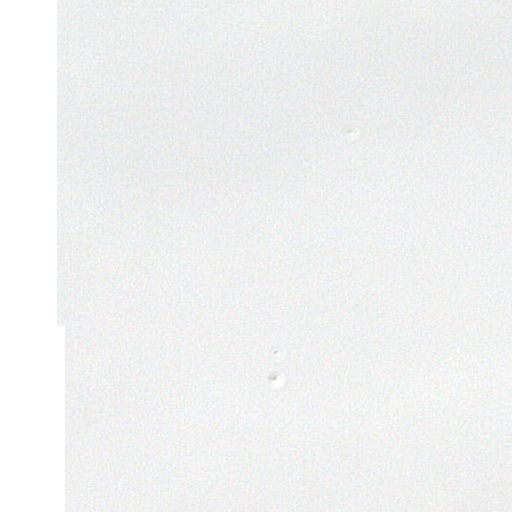

In [53]:
randi = random.randint(0, len(slide_paths_pos))
slide = openslide.OpenSlide(slide_paths_pos[randi])
slide.read_region(grid_pos[randi][random.randint(0, 100)], level = 0, size = [512, 512])

In [57]:
class TileDataset(Dataset):
    def __init__(self, image_paths, grids, tile_size=(512,512), label = 0, transform=None):

        self.image_paths = image_paths
        self.grids = grids
        self.tile_size = tile_size
        self.label = label
        self.transform = transform

    def __len__(self):
        return sum(len(grid) for grid in self.grids)
    
    def __getitem__(self, idx):
        # Find which image and grid the idx belongs to
        cumulative_tiles = 0
        for img_idx, grid in enumerate(self.grids):
            if idx < cumulative_tiles + len(grid):
                tile_idx = idx - cumulative_tiles
                image_path = self.image_paths[img_idx]
                x, y = grid[tile_idx]
                break
            cumulative_tiles += len(grid)

        # Load the whole-slide image
        slide = openslide.OpenSlide(image_path)
        
        # Extract the tile at level 0
        tile = slide.read_region((x, y), 0, self.tile_size).convert("RGB")
        
        # Apply transformations if specified
        if self.transform:
            tile = self.transform(tile)
        
        # Close the slide to free resources
        slide.close()
        
        return tile, self.label


In [70]:
transform = transforms.Compose([
    transforms.ToTensor()])

In [71]:
pos_dataset = TileDataset(slide_paths_pos, grid_pos, tile_size=(512,512), label = 1, transform=transform)
neg_dataset = TileDataset(slide_paths_neg, grid_neg, tile_size=(512,512), label = 0, transform=transform)

In [72]:
dataset = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset])

In [73]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [74]:
dataloader

Tiles shape: torch.Size([16, 3, 512, 512])
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1])


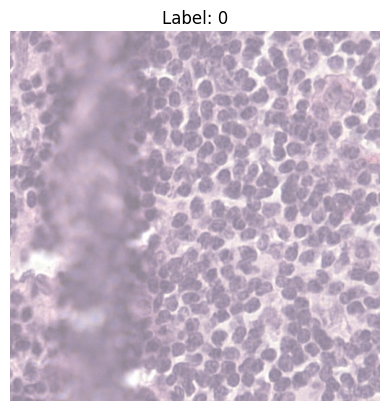

In [75]:
tiles, labels = next(iter(dataloader))

print("Tiles shape:", tiles.shape)       # Shape of the batch, e.g., torch.Size([16, 3, 256, 256])
print("Labels:", labels)                 # Corresponding labels, e.g., tensor([1, 0, 1, 0, ...])

# Optionally, display the first tile in the batch
import matplotlib.pyplot as plt

# Convert the first tile tensor to a numpy array and plot it
tile_to_show = tiles[0].permute(1, 2, 0).numpy() * 0.5 + 0.5  # Unnormalize if normalized earlier
plt.imshow(tile_to_show)
plt.title(f"Label: {labels[0].item()}")
plt.axis("off")
plt.show()